# Import

In [1]:
# !pip install -q rdkit
# !pip install -q albumentations
# !pip install -q torch_geometric

# !pip install accelerate -U
# !pip install -q tokenizer
# !pip install -q transformer
# !pip install -q tokenizers

# import accelerate
# accelerate.__version__

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import random
import os

from tqdm import tqdm

import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment',None)

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

from rdkit import DataStructs
from rdkit.Chem import PandasTools, AllChem

In [4]:
import os
import random
import numpy as np
import torch

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [241]:
class CFG:
    SEED = 0
    BATCH_SIZE = 128
    EPOCHS = 1024
    LEARNING_RATE = 0.003

<br></br>

# Data Load

In [9]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')

In [10]:
train_df.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


<br></br>

# EDA

In [11]:
# train_df.describe()

In [12]:
# num_features = train_df.columns[train_df.dtypes!='object'].tolist()
# for i,col in enumerate(num_features):

#     fig = plt.figure(figsize=(15,7))
#     fig.add_subplot(121)
#     sns.histplot(train_df[col],bins=20)
#     plt.grid()

#     fig.add_subplot(122)
#     sns.histplot(np.log(train_df[col]+1e-3),bins=20)
#     plt.grid()

#     plt.suptitle('[{}/{}] {}'.format(i+1,len(num_features),col))
#     plt.tight_layout()
#     plt.show()

# # -> ['Molecular_Weight','Molecular_PolarSurfaceArea']

In [13]:
# cols = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
# for col in cols:
#     print(col)
#     plt.figure(figsize=(15,7))
#     sns.scatterplot(x=train_df[col],y=train_df['HLM'])
#     plt.grid()
#     plt.show()

In [14]:
# cols = ['Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds']
# for col in cols:
#     print(col)
#     plt.figure(figsize=(15,7))
#     sns.boxplot(x=train_df[col],y=train_df.MLM)
#     plt.show()

In [15]:
# train_df.nunique()

In [16]:
# lists = sorted(train_df['Num_H_Acceptors'].unique())
# for v in lists:
#     print('########',v)
#     d = train_df[train_df['Num_H_Acceptors']==v]
    
#     cols = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
#     for col in cols:
#         print(col)
#         plt.figure(figsize=(15,7))
#         sns.scatterplot(x=d[col],y=d['HLM'])
#         plt.grid()
#         plt.show()

In [17]:
# tmp = train_df['MLM']

# plt.figure(figsize=(15,7))
# sns.scatterplot(x=train_df['MLM'],y=train_df['HLM'])
# plt.grid()
# plt.show()

<br></br>

# Pre-Processing

<br>

## Set target range to [0,100]

- [Dacon](https://dacon.io/competitions/official/236127/talkboard/409051?page=1&dtype=recent)에 따르면 100이 넘는 값도 나올 수 있음

In [18]:
# targets = ['MLM','HLM']
# for t in targets:
#     train_df[t] = [0 if x<0 else
#                    100 if x>100 else
#                    x for x in train_df[t]]

<br>

## Make molecule features

In [19]:
# Molecule to MorganFingerprint
def mol2fp(mol):
    radius, nBits = 6, 4096
    #radius, nBits = 2, 4096
    fp = AllChem.GetHashedMorganFingerprint(mol, radius=radius, nBits=nBits)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

In [20]:
# (1) SMILES를 통해 Molecule(분자구조) 생성
PandasTools.AddMoleculeColumnToFrame(train_df,'SMILES','Molecule')
PandasTools.AddMoleculeColumnToFrame(test_df ,'SMILES','Molecule')

In [21]:
from sklearn.feature_selection import VarianceThreshold

In [22]:
# (2) Morgan Fingerprint column 추가
train_df["FPs"] = train_df.Molecule.apply(mol2fp)
test_df ["FPs"] = test_df .Molecule.apply(mol2fp)

In [23]:
# (3) Morgan Fingerprint 중, variance가 0.05보다 작은 컬럼들을 지우기
feature_select = VarianceThreshold(threshold=0.05)

# 일부사용
tr_fps_selected = feature_select.fit_transform(np.stack(train_df['FPs']))
te_fps_selected = feature_select.transform(np.stack(test_df['FPs']))
print(tr_fps_selected.shape[1])

# # 전체사용
# tr_fps_selected = np.stack(train_df['FPs'])
# te_fps_selected = np.stack(test_df ['FPs'])

fps_names = ['fps'+str(i+1) for i in range(tr_fps_selected.shape[1])]

train_df = pd.concat([
    train_df.drop('FPs',axis=1),
    pd.DataFrame(tr_fps_selected,columns=fps_names),
],axis=1)

test_df = pd.concat([
    test_df.drop('FPs',axis=1),
    pd.DataFrame(te_fps_selected,columns=fps_names),
],axis=1)

251


In [24]:
# img = tr_fps_selected[4].reshape(64,64)
# plt.imshow(img)

In [25]:
# train_df['fps_raw_sum'] = np.sum(train_df[fps_names].values,axis=1)
# test_df ['fps_raw_sum'] = np.sum(test_df [fps_names].values,axis=1)

In [26]:
# for col in tqdm(fps_names):
#     train_df[col] = np.where(train_df[col]==0,0,1)
#     test_df [col] = np.where(test_df [col]==0,0,1)

In [27]:
# train_df['fps_dummy_sum'] = np.sum(train_df[fps_names].values,axis=1)
# test_df ['fps_dummy_sum'] = np.sum(test_df [fps_names].values,axis=1)

In [28]:
# 사용할 column만 추출
features = ['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors',
            'Num_RotatableBonds','LogD','Molecular_PolarSurfaceArea']
fps_features = [col for col in train_df.columns if col.find('fps')==0]
smiles_feature = 'SMILES'
targets  = ['MLM','HLM']

train_df = train_df[features+fps_features+[smiles_feature]+targets]
test_df  = test_df[features+fps_features+[smiles_feature]]

In [29]:
train_df.shape

(3498, 261)

<br>

## Imputaion

In [30]:
from sklearn.impute import SimpleImputer

In [31]:
def null_check(data):
    d = data.copy()
    null_info = d.isnull().sum()
    null_info = null_info[null_info!=0]
    display(null_info)

In [32]:
print('> train')
null_check(train_df)

print('> test')
null_check(test_df)

> train


AlogP    2
dtype: int64

> test


AlogP    1
dtype: int64

In [33]:
tr_null_loc = train_df.AlogP.isnull()
te_null_loc = test_df .AlogP.isnull()

train_df.AlogP[tr_null_loc] = train_df.LogD[tr_null_loc]
test_df .AlogP[te_null_loc] = test_df .LogD[te_null_loc]

In [34]:
print('> train')
null_check(train_df)

print('> test')
null_check(test_df)

> train


Series([], dtype: int64)

> test


Series([], dtype: int64)

<br>

## Train Test Split

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
tr_df, va_df = train_test_split(train_df,test_size=0.25,shuffle=True,random_state=CFG.SEED)
te_df = test_df.copy()

In [37]:
len(tr_df), len(va_df), len(te_df)

(2623, 875, 483)

<br>

## Scaling

In [38]:
from sklearn.preprocessing import MinMaxScaler

scaling_features = tr_df.columns.difference(['MLM','HLM','SMILES'])
scalers = {}
for f in scaling_features:
    scaler = MinMaxScaler()
    tr_df[f] = scaler.fit_transform(np.array(tr_df[f]).reshape(-1,1))
    va_df[f] = scaler.transform(np.array(va_df[f]).reshape(-1,1))
    te_df[f] = scaler.transform(np.array(te_df[f]).reshape(-1,1))
    scalers[f] = scaler

<br>

## Interaction Term

In [39]:
import warnings
from tqdm import trange

def get_abs_corr(x,y):
    return np.abs(np.corrcoef(x,y))[0,1]

class InteractionTerm:
    def __init__(self):
        pass
    
    def fit(self,data,num_features,corr_cutoff=0.7):
        warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        
        d = data.copy()
        self.interaction_list = []
        for i in trange(len(num_features),desc='fitting...'):
            for j in range(len(num_features)):
                if i>j:
                    col_i = num_features[i]
                    col_j = num_features[j]
                    
                    # 상관계수가 cutoff보다 큰 경우에는 interaction을 생성하지 않음
                    if (get_abs_corr(d[col_i]*d[col_j],d[col_i])>=corr_cutoff) | (get_abs_corr(d[col_i]*d[col_j],d[col_j])>=corr_cutoff):
                        pass
                    else:
                        self.interaction_list.append(f'{col_i}*{col_j}')
    
    def transform(self,data):
        d = data.copy()
        print('> the number of interaction term:',len(self.interaction_list))
        for interaction in self.interaction_list:
            col_i,col_j = interaction.split('*')
            d[interaction] = d[col_i]*d[col_j]
        return d
    
    def fit_transform(self,data,num_features,corr_cutoff=0.7):
        self.fit(data,num_features,corr_cutoff)
        return self.transform(data)

In [40]:
# num_features = features + fps_features

In [41]:
# interaction_maker = InteractionTerm()
# interaction_maker.fit(
#     data=tr_df,
#     num_features=num_features,
#     corr_cutoff=0.05,
# )
# tr_df = interaction_maker.transform(tr_df)
# va_df = interaction_maker.transform(va_df)
# te_df = interaction_maker.transform(te_df)

In [42]:
# tr_df.shape

<br>

## Target Transformation

In [43]:
# for t in targets:
#     tr_df[t] = np.log(tr_df[t]+1e-3)
#     va_df[t] = np.log(va_df[t]+1e-3)

In [44]:
# def inverse_transform(x):
#     return torch.exp(x)-1e-3

In [45]:
inverse_transform = None

<br></br>

# Custom Dataset

In [46]:
# https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/

In [47]:
# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

# Pytorch and Pytorch Geometric
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader

In [48]:
def get_atom_features(atom, 
                      use_chirality = True, 
                      hydrogens_implicit = True):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """

    # define list of permitted atoms
    
    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
    
    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms
    
    # compute atom features
    
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    
    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    
    is_in_a_ring_enc = [int(atom.IsInRing())]
    
    is_aromatic_enc = [int(atom.GetIsAromatic())]
    
    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]
    
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
                                    
    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
    
    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)

In [49]:
def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """

    if x not in permitted_list:
        x = permitted_list[-1]

    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

    return binary_encoding

In [50]:
def get_bond_features(bond, 
                      use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc
    
    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)

In [51]:
def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y):
    """
    Inputs:
    
    x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
    y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)
    
    Outputs:
    
    data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning
    
    """
    
    data_list = []
    
    for (smiles, y_val) in tqdm(zip(x_smiles, y),total=len(x_smiles)):
        
        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)

        # get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_edges = 2*mol.GetNumBonds()
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

        # construct node feature matrix X of shape (n_nodes, n_node_features)
        X = np.zeros((n_nodes, n_node_features))

        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)
            
        X = torch.tensor(X, dtype = torch.float)
        
        # construct edge index array E of shape (2, n_edges)
        (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
        torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
        torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
        E = torch.stack([torch_rows, torch_cols], dim = 0)
        
        # construct edge feature array EF of shape (n_edges, n_edge_features)
        EF = np.zeros((n_edges, n_edge_features))
        
        for (k, (i,j)) in enumerate(zip(rows, cols)):
            
            EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))
        
        EF = torch.tensor(EF, dtype = torch.float)
        
        # construct label tensor
        y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)
        
        # construct Pytorch Geometric data object and append to data list
        data_list.append(Data(x = X, edge_index = E, edge_attr = EF))##, y = y_tensor))

    return data_list

In [52]:
# tmp = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(tr_df['SMILES'],tr_df[targets[0]])

In [53]:
# from rdkit import Chem
# import torch_geometric

# def make_graph_dataset(smiles_data):
#     # 데이터 객체 리스트 초기화
#     data_list = []
#     for smiles in tqdm(smiles_data):
#         mol = Chem.MolFromSmiles(smiles)
#         num_atoms = mol.GetNumAtoms()
#         atom_features = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
#         edge_indices = []
#         edge_features = []

#         for bond in mol.GetBonds():
#             i = bond.GetBeginAtomIdx()
#             j = bond.GetEndAtomIdx()
#             edge_indices.append((i, j))
#             edge_indices.append((j, i))
#             edge_features += [bond.GetBondTypeAsDouble()] * 2

#         x = torch.tensor(atom_features, dtype=torch.float).view(num_atoms, 1)
#         edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
#         edge_attr = torch.tensor(edge_features, dtype=torch.float).view(-1, 1)

#         data = torch_geometric.data.Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
#         data_list.append(data)
    
#     return torch_geometric.data.Batch.from_data_list(data_list)

In [54]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, targets, smiles, is_test=False):
        self.data = data.copy()
        self.targets = targets
        self.smiles = smiles
        self.is_test = is_test
        
        self.graph_features = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(
            data[smiles],np.zeros(len(data)))

        if not self.is_test:
            self.target_features = self.data[self.targets].values
            self.num_features = self.data.drop(columns=targets+[smiles],axis=1).values
        else:
            self.num_features = self.data.drop(columns=[smiles],axis=1).values

    def __getitem__(self, index):
        if self.is_test:
            return (
                torch.Tensor(self.num_features[index]),
                self.graph_features[index],
            )
        else:
            return (
                torch.Tensor(self.num_features[index]),
                self.graph_features[index],
                torch.Tensor(self.target_features[index]),
            )
        
    def __len__(self):
        return len(self.data)

In [55]:
def collate_fn(items):
    global smiles
    feats   = [item[0] for item in items]
    graphs  = [item[1] for item in items]
    targets = [item[2] for item in items if len(item)>2]
    
    return torch.stack(feats), graphs, torch.stack(targets) if targets else None

In [56]:
shuffle = False
num_workers = 0
pin_memory = False

In [57]:
train_dataset = CustomDataset(tr_df, ['MLM','HLM'], 'SMILES', False)
val_dataset   = CustomDataset(va_df, ['MLM','HLM'], 'SMILES', False)
test_dataset  = CustomDataset(te_df, ['MLM','HLM'], 'SMILES', True)

100%|██████████| 483/483 [00:01<00:00, 388.44it/s]


In [58]:
train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=shuffle, pin_memory=pin_memory, num_workers=num_workers, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset  , batch_size=CFG.BATCH_SIZE, shuffle=shuffle, pin_memory=pin_memory, num_workers=num_workers, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset , batch_size=CFG.BATCH_SIZE, shuffle=shuffle, pin_memory=pin_memory, num_workers=num_workers, collate_fn=collate_fn)

In [59]:
# [graph for feat,graph,target in val_loader][0]

In [60]:
# tmp = [graph for feat,graph,target in val_loader][0]
# [t.x.shape for t in tmp]

<br></br>

# Modeling

## Define Model

In [61]:
import torchvision.models as models

In [62]:
from torch_geometric.nn import global_add_pool, GCNConv, NNConv

In [145]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GraphNeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(GraphNeuralNet, self).__init__()

        self.conv1 = GCNConv(input_size , hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)
        self.conv3 = GCNConv(hidden_size, hidden_size)
        self.conv4 = GCNConv(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        
        self.bn = nn.BatchNorm1d(hidden_size)
        self.activation = nn.SiLU()
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, data):
        batch, x, edge_index = data.batch, data.x, data.edge_index

        x = self.conv1(x, edge_index)
        #x = self.bn(x)
        x = self.activation(x)
        #x = self.dropout(x)

        x = self.conv2(x, edge_index)
        #x = self.bn(x)
        x = self.activation(x)
        #x = self.dropout(x)

        x = self.conv3(x, edge_index)
        #x = self.bn(x)
        x = self.activation(x)
        #x = self.dropout(x)
        
        x = self.conv4(x, edge_index)
        #x = self.bn(x)
        x = self.activation(x)
        #x = self.dropout(x)
        
        x = global_add_pool(x,batch)
        x = self.fc(x)

        return x

In [305]:
# https://www.kaggle.com/code/matteobellitti/gnn-f1-score-0-76/notebook
class GCN(torch.nn.Module):
    def __init__(self,num_node_features,num_edge_features,hidden_size,output_size,dropout_rate):
        super().__init__()
        
        convC1 = self._get_conv_layer(num_edge_features,hidden_size,num_node_features,dropout_rate)
        convC2 = self._get_conv_layer(num_edge_features,hidden_size,num_node_features,dropout_rate)
        convC3 = self._get_conv_layer(num_edge_features,hidden_size,num_node_features,dropout_rate)
        convC4 = self._get_conv_layer(num_edge_features,hidden_size,num_node_features,dropout_rate)
        
        # in_channels, out_channels, nn.Module
        self.convC1 = NNConv(num_node_features,num_node_features,convC1)
        self.convC2 = NNConv(num_node_features,num_node_features,convC2)
        self.convC3 = NNConv(num_node_features,num_node_features,convC3)
        self.convC4 = NNConv(num_node_features,num_node_features,convC4)
        
        self.fc = nn.Linear(num_node_features,output_size)
        
    def _get_conv_layer(self,num_edge_features,hidden_size,num_node_features,dropout_rate):
        # shape must be num_edge_features -> in_channels*out_channels
        layer = nn.Sequential(
            nn.Linear(num_edge_features,hidden_size),
            #nn.BatchNorm1d(hidden_size),
            nn.SiLU(),
            #nn.Dropout(dropout_rate),
            nn.Linear(hidden_size,num_node_features*num_node_features)
        )
        return layer

    def forward(self, data):
        batch, x, edge_index, edge_attr = data.batch, data.x, data.edge_index, data.edge_attr

        # convolution layers with skip connection
        x = F.relu(x - self.convC1(x, edge_index, edge_attr))
        x = F.relu(x - self.convC2(x, edge_index, edge_attr))
        #x = F.relu(x - self.convC3(x, edge_index, edge_attr))
        #x = F.relu(x - self.convC4(x, edge_index, edge_attr))
        
        # x = F.dropout(x, training=self.training)
        x = global_add_pool(x,batch)
        x = self.fc(x)

        return x

In [327]:
class MultiTaskModel(nn.Module):
    def __init__(self, graph_input_size, num_edge_features, feature_input_size, output_size, hidden_size, dropout_rate, device):
        super(MultiTaskModel, self).__init__()
        self.device = device
        image_output_size = 50
        feature_output_size = 50
        
        #self.image_layer = GraphNeuralNet(graph_input_size,hidden_size,image_output_size,dropout_rate)

        self.image_layer = GCN(graph_input_size,num_edge_features,hidden_size,image_output_size,dropout_rate)
        self.feature_layer = self._get_dnn_layer(feature_input_size,hidden_size,feature_output_size,dropout_rate)
        self.fc = self._get_dnn_layer(image_output_size+feature_output_size,hidden_size,output_size,dropout_rate)
        
        #self.image_layer = GCN(graph_input_size,num_edge_features,hidden_size,output_size,dropout_rate)
        
    def _get_dnn_layer(self,input_size,hidden_size,output_size,dropout_rate):
        activation = nn.ReLU() #nn.SiLU()
        layer = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.BatchNorm1d(hidden_size),
            activation,
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_size,hidden_size),
            nn.BatchNorm1d(hidden_size),
            activation,
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_size,hidden_size),
            nn.BatchNorm1d(hidden_size),
            activation,
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_size,hidden_size),
            nn.BatchNorm1d(hidden_size),
            activation,
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_size,output_size),
        )
        return layer
    
    def forward(self, feature, image):
        image_output = torch.stack([self.image_layer(img.to(self.device)) for img in image])
        image_output = image_output[:,-1,:]
        
        feature_output = self.feature_layer(feature)
        
        combined = torch.cat((image_output,feature_output),dim=1)
        output = self.fc(combined)
        
        return output

    # def forward(self, feature, image):
    #     image_output = torch.stack([self.image_layer(img.to(self.device)) for img in image])
    #     image_output = image_output[:,-1,:]
    #     return image_output

<br>

## Training

In [328]:
class MultiRMSELoss(nn.Module):
    def __init__(self):
        super(MultiRMSELoss, self).__init__()

    def forward(self, output, target):
        loss1 = torch.sqrt(torch.mean((output[:,0]-target[:,0])**2))
        loss2 = torch.sqrt(torch.mean((output[:,1]-target[:,1])**2))
        loss = 0.5*loss1+0.5*loss2
        return loss

In [329]:
import gc
import numpy as np
import torch
import torch.nn as nn
import time

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        if self.path!='':
            torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

        
def train(
    model, criterion, optimizer, train_loader, valid_loader, epochs,
    early_stopping, device='cpu', scheduler=None, metric_period=1, 
    verbose=True, save_model_path = './mc/best_model.pt',
    use_best_model=True,
    inverse_transform=None,
):  
    seed_everything(CFG.SEED)
    model.to(device)

    best_loss  = 999999999
    best_epoch = 1
    best_model = None
    is_best    = np.nan
    
    start_time = time.time()
    epoch_s = time.time()
    
    for epoch in range(1, epochs+1):
        gc.collect()
        
        model.train()
        train_loss = []
        for feat,img,target in train_loader:
            feat = feat.to(device)
            #img = img.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            output = model(feat,img)#.float()
            
            if inverse_transform is not None:
                output = inverse_transform(output)
                target = inverse_transform(target)
            
            loss = criterion(output, target)
            loss.backward()  # Getting gradients
            optimizer.step() # Updating parameters

            train_loss.append(loss.item())

        valid_loss = validation(model, valid_loader, criterion, device, inverse_transform)
        epoch_e = time.time()
            
        if scheduler is not None:
            scheduler.step(valid_loss)

        # update the best epoch & best loss
        if (best_loss > valid_loss) | (epoch==1):
            best_epoch = epoch
            best_loss = valid_loss
            best_model = model
            is_best = 1
            torch.save(best_model.state_dict(), save_model_path)
        else:
            is_best = 0
            if not use_best_model:
                torch.save(best_model.state_dict(), save_model_path)
            
        # 결과물 printing
        if (verbose) & (epoch % metric_period == 0):
            mark = '*' if is_best else ' '
            epoch_str = str(epoch).zfill(len(str(epochs)))
            progress = '{}[{}/{}] loss: {:.5f}, val_loss: {:.5f}, best_epoch: {}, elapsed: {:.2f}s, total: {:.2f}s, remaining: {:.2f}s'\
                .format(
                    mark,
                    epoch_str,
                    epochs,
                    np.mean(train_loss),
                    valid_loss,
                    best_epoch,
                    epoch_e-epoch_s,
                    epoch_e-start_time,
                    (epoch_e-epoch_s)*(epochs-epoch)/metric_period,
                )
            epoch_s = time.time()
            print(progress)

        # early stopping 여부를 체크. 현재 과적합 상황 추적
        if early_stopping is not None:
            early_stopping(valid_loss, model)
            if early_stopping.early_stop:
                break

    return best_model

def validation(model, valid_loader, criterion, device, inverse_transform):
    valid_loss = []
    with torch.no_grad():
        for feat,img,target in valid_loader:
            feat = feat.to(device)
            #img = img.to(device)
            target = target.to(device)
            
            output = model(feat,img)#.float()
            
            if inverse_transform is not None:
                output = inverse_transform(output)
                target = inverse_transform(target)
            
            loss = criterion(output, target)
            valid_loss.append(loss.item())

    return np.mean(valid_loss)

def predict(best_model,loader,device,inverse_transform):
    best_model.to(device)

    true_list = []
    pred_list = []
    with torch.no_grad():
        for feat,img,target in iter(loader):
            feat = feat.to(device)
            #img = img.to(device)
            target = target.to(device)

            output = best_model(feat,img)
            
            if inverse_transform is not None:
                output = inverse_transform(output)
                target = inverse_transform(target)

            true_list.append(target)
            pred_list.append(output)

    trues = torch.cat(true_list,dim=0)
    preds = torch.cat(pred_list,dim=0)

    trues = trues.cpu().numpy()
    preds = preds.cpu().numpy()

    return trues, preds

In [330]:
graph_input_size = [graph for feat,graph,target in val_loader][0][0].x.shape[1]
num_edge_features = [graph for feat,graph,target in train_loader][0][0].edge_attr.shape[1]
feature_input_size = [feat for feat,smiles,target in train_dataset][0].shape[0]
print(graph_input_size,num_edge_features,feature_input_size)

output_size = 2
hidden_size = 64
dropout_rate = 0.05

79 10 258


In [331]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [332]:
CFG.LEARNING_RATE = 0.05

In [333]:
model = MultiTaskModel(
    graph_input_size,
    num_edge_features,
    feature_input_size,
    output_size,
    hidden_size,
    dropout_rate,
    device,
)

criterion = MultiRMSELoss()
# optimizer= torch.optim.Adam(model.parameters(), lr=CFG.LEARNING_RATE)#, weight_decay=5e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.LEARNING_RATE)
# optimizer = torch.optim.SGD(model.parameters(), lr=CFG.LEARNING_RATE, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-7, verbose=False)
scheduler = None
# early_stopping = EarlyStopping(patience=10,verbose=False,path='')
early_stopping = None

In [335]:
torch.cuda.empty_cache()
gc.collect()

0

In [336]:
best_model = train(
    model, criterion, optimizer, train_loader, val_loader,
    CFG.EPOCHS, early_stopping,
    device=device, scheduler=scheduler, 
    metric_period=1, verbose=True,
    save_model_path='./mc/best_model.pt',
    use_best_model=True,
    inverse_transform=inverse_transform,
)

*[0001/1024] loss: 44.52867, val_loss: 37.84247, best_epoch: 1, elapsed: 6.29s, total: 6.29s, remaining: 6434.20s
*[0002/1024] loss: 36.27830, val_loss: 36.03349, best_epoch: 2, elapsed: 6.30s, total: 12.61s, remaining: 6437.67s
 [0003/1024] loss: 35.54996, val_loss: 36.06046, best_epoch: 2, elapsed: 6.31s, total: 18.94s, remaining: 6443.72s
 [0004/1024] loss: 35.52649, val_loss: 36.13923, best_epoch: 2, elapsed: 6.30s, total: 25.24s, remaining: 6427.24s
*[0005/1024] loss: 35.37085, val_loss: 35.83323, best_epoch: 5, elapsed: 6.31s, total: 31.56s, remaining: 6434.48s
 [0006/1024] loss: 35.22232, val_loss: 36.01228, best_epoch: 5, elapsed: 6.30s, total: 37.89s, remaining: 6418.36s
 [0007/1024] loss: 35.40407, val_loss: 35.83392, best_epoch: 5, elapsed: 6.30s, total: 44.19s, remaining: 6410.56s
*[0008/1024] loss: 35.26721, val_loss: 35.77350, best_epoch: 8, elapsed: 6.30s, total: 50.49s, remaining: 6399.01s
 [0009/1024] loss: 35.24161, val_loss: 35.79808, best_epoch: 8, elapsed: 6.29s, t

KeyboardInterrupt: 

<br>

## Inference

In [337]:
best_model = MultiTaskModel(
    graph_input_size,
    num_edge_features,
    feature_input_size,
    output_size,
    hidden_size,
    dropout_rate,
    device,
)
best_model.load_state_dict(torch.load('./mc/best_model.pt'))

<All keys matched successfully>

In [338]:
tr_true, tr_pred = predict(best_model,train_loader,device,inverse_transform)
va_true, va_pred = predict(best_model,val_loader  ,device,inverse_transform)

In [339]:
(MultiRMSELoss()(torch.tensor(tr_true),torch.tensor(tr_pred)),
 MultiRMSELoss()(torch.tensor(va_true),torch.tensor(va_pred)))

(tensor(27.5448), tensor(32.8520))

In [340]:
tr_true[:10].round(1), tr_pred[:10].round(1)
# va_true[:10].round(1), va_pred[:10].round(1)

(array([[41.9, 24.9],
        [ 2. , 57.7],
        [ 0.4,  0.4],
        [ 2.9,  5.4],
        [17.5, 83. ],
        [15. , 51.1],
        [ 0.9,  6.4],
        [ 1.9,  5.6],
        [99.9, 99.9],
        [30. , 77. ]], dtype=float32),
 array([[44.4, 66.2],
        [24.6, 45.7],
        [29.8, 51.5],
        [11. , 18. ],
        [33.8, 57.5],
        [23.1, 43.3],
        [39.3, 47.5],
        [19.5, 34.8],
        [59.6, 69. ],
        [57.4, 70.4]], dtype=float32))

In [341]:
def abline(intercept,slope):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, linestyle='--', color='red')

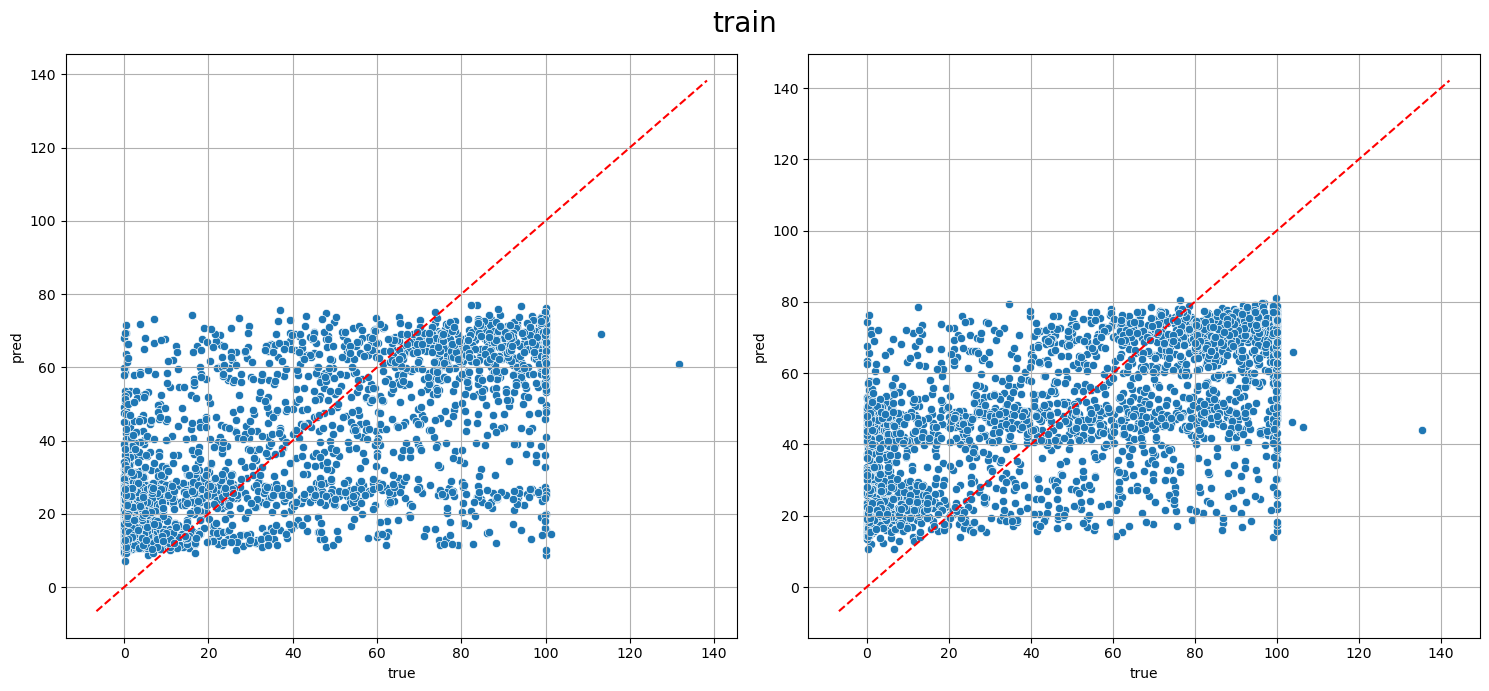

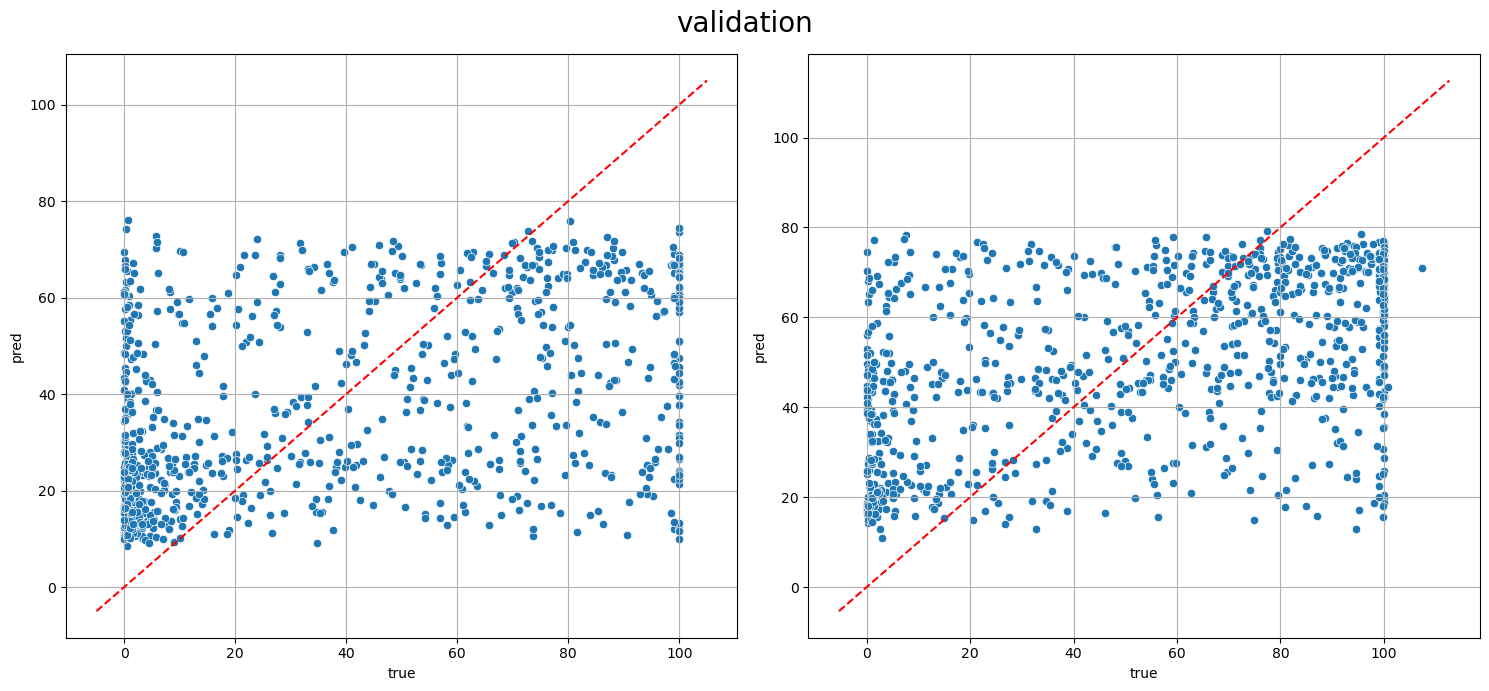

In [342]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
sns.scatterplot(x=tr_true[:,0],y=tr_pred[:,0])
abline(0,1)
plt.xlabel('true')
plt.ylabel('pred')
plt.grid()
fig.add_subplot(122)
sns.scatterplot(x=tr_true[:,1],y=tr_pred[:,1])
abline(0,1)
plt.xlabel('true')
plt.ylabel('pred')
plt.grid()
plt.suptitle('train',fontsize=20)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
sns.scatterplot(x=va_true[:,0],y=va_pred[:,0])
abline(0,1)
plt.xlabel('true')
plt.ylabel('pred')
plt.grid()
fig.add_subplot(122)
sns.scatterplot(x=va_true[:,1],y=va_pred[:,1])
abline(0,1)
plt.xlabel('true')
plt.ylabel('pred')
plt.grid()
plt.suptitle('validation',fontsize=20)
plt.tight_layout()
plt.show()